In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import skimage.filters as filters
import matplotlib.patches as mpatches

In [159]:
def Sample(ppmu2=1,sizex=1e2,sizey=1e2):
    nps=int(ppmu2*sizex*sizey)
    ps=np.array([0,0])
    for i in range(nps):
        x,y=sizex*np.random.rand(),sizey*np.random.rand()
        ps=np.vstack((ps,[x,y]))
    ps=np.delete(ps,0,0)
    return ps

def Sample_array(x0,y0,sample,sigma1,sigma2,M=100,Nx=512,Ny=512,pxszx=10,pxszy=10):
    xsz=Nx*pxszx/M
    ysz=Ny*pxszy/M
    xran=[x0-xsz/2,x0+xsz/2]
    yran=[y0-ysz/2,y0+ysz/2]
    xs=np.arange(xran[0],xran[1],pxszx/M)
    ys=np.arange(yran[0],yran[1],pxszy/M)
    im=np.zeros((xs.size,ys.size))
    sarr=np.zeros((xs.size,ys.size))
    for particle in sample:
        if xran[0]<particle[0] and xran[1]>particle[0]:
            if yran[0]<particle[1] and yran[1]>particle[1]:
                indx=min(range(len(xs)), key=lambda i: abs(xs[i]-particle[0]))
                indy=min(range(len(ys)), key=lambda i: abs(ys[i]-particle[1]))
                sarr[indx,indy]+=1
    return sarr,xran,yran

def Diffraction_limited(sarr,sigma1,sigma2,M=100,pxszx=10):
    im=filters.gaussian(sarr,sigma=sigma1*M/pxszx)
    return im    
def Image_evol(data,sigma1,noiseA,noisestd,M=100,pxszx=10):
    n0,n1,n2=data.shape[0],data.shape[1],data.shape[2]
    ims=np.zeros_like(data)
    for i,sarr in enumerate (data):
        ims[i]=filters.gaussian(sarr,sigma=sigma1*M/pxszx)
    ims+=noiseA*np.random.normal(0,noisestd, size=(n0,n1,n2))
    return ims

def evolve(D,p):
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            n0=D[i,j]
            ndie=0
            for ni in range (int(n0)):
                r=np.random.rand()
                if r<p:
                    ndie+=1
            D[i,j]-=ndie
    return D

def temporal_evolution(distr,p,Nt):
    data0=np.zeros_like(distr)
    data=np.stack((data0,distr))
    d=distr
    for i in range (Nt):
        d=evolve(d,p)
        data=np.append(data,[d],axis=0)
    data=np.delete(data,0,0)
    return data     
    

In [206]:
s=Sample()

In [207]:
sarr,xran,yran=Sample_array(x0=20,y0=20,sample=s,sigma1=1,sigma2=1,M=50,Nx=100,Ny=100)
im=Image(sarr,sigma1=0.3,sigma2=1,M=50,pxszx=10)

In [208]:
evol=temporal_evolution(sarr,0.05,100)
ims=Image_evol(evol,sigma1=0.3,noiseA=0.05,noisestd=0.2,M=50,pxszx=10)

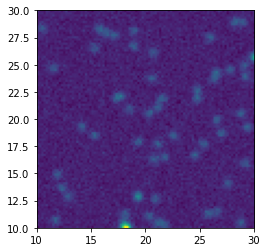

In [209]:
plt.imshow(ims[40],extent=[xran[0],xran[1],yran[0],yran[1]])

In [210]:
def ROI(im,mask):
    label_image = label(mask)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(im)
    rois=np.array([0,0,0,0])
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        rois=np.vstack((rois,[minc,minr,maxc,maxr]))
    rois=np.delete(rois,0,0)
    return rois

In [211]:
def Apply_thresh(im,thresh):
    mask=im>thresh
    return mask

In [212]:
def cluster(rois,image_evol,number,ti):
    r=rois[number]
    return image_evol[ti][r[1]:r[3],r[0]:r[2]]

In [213]:
def cluster_evol(rois,image_evol,number):
    r=rois[number]
    roi_evol=image_evol[:,r[1]:r[3],r[0]:r[2]]
    s=[np.sum(im) for im in roi_evol]
    return s

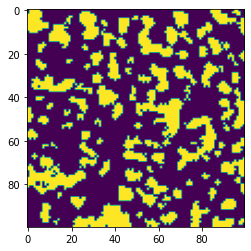

In [214]:
im=ims[0]
mask=Apply_thresh(im,0.05)
plt.imshow(mask)

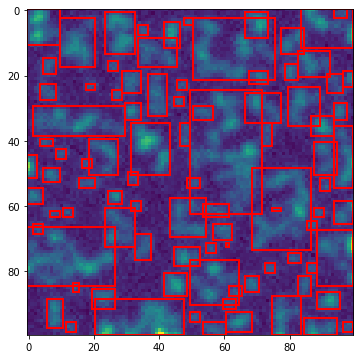

In [215]:
rois=ROI(im,mask)

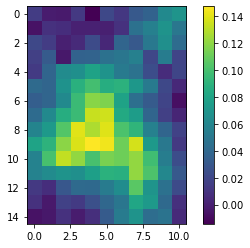

In [216]:
cluster_number=5
ti=0
plt.imshow(cluster(rois,ims,cluster_number,ti))
plt.colorbar()

Text(0.5, 1.0, 'Time evolution: cluster 5')

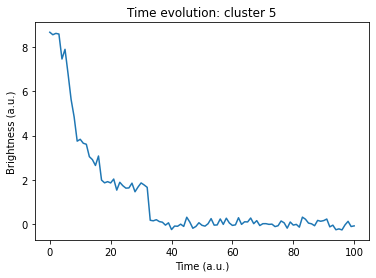

In [217]:
plt.plot(cluster_evol(rois,ims,cluster_number))
plt.xlabel('Time (a.u.)')
plt.ylabel('Brightness (a.u.)')
plt.title('Time evolution: cluster {}'.format(cluster_number))